Bias and Fairness Audit on the COMPAS Recidivism Dataset

In [3]:
# 📦 Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 🧠 Fairness Toolkit
from aif360.datasets import CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing

# ⚙️ ML
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Ignore warnings for clarity
import warnings
warnings.filterwarnings("ignore")

print("✅ Libraries successfully imported")


✅ Libraries successfully imported


In [8]:
# Load COMPAS dataset from AI Fairness 360
dataset = CompasDataset()

# Convert to pandas for exploration
df = pd.DataFrame(dataset.convert_to_dataframe()[0])

print("✅ COMPAS dataset loaded successfully")
df.head()


✅ COMPAS dataset loaded successfully


,sex,age,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,age_cat=25 - 45,age_cat=Greater than 45,age_cat=Less than 25,...,c_charge_desc=Viol Injunct Domestic Violence,c_charge_desc=Viol Injunction Protect Dom Vi,c_charge_desc=Viol Pretrial Release Dom Viol,c_charge_desc=Viol Prot Injunc Repeat Viol,c_charge_desc=Violation License Restrictions,c_charge_desc=Violation Of Boater Safety Id,c_charge_desc=Violation of Injunction Order/Stalking/Cyberstalking,c_charge_desc=Voyeurism,c_charge_desc=arrest case no charge,two_year_recid
1,0.0,69.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,34.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,24.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,0.0,44.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,41.0,1.0,0.0,0.0,0.0,14.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [9]:
print("📊 Dataset Info:\n")
print(df.info())

print("\n🔍 Summary Statistics:\n")
print(df.describe())

print("\n🎯 Target Distribution:")
print(df['two_year_recid'].value_counts(normalize=True))


📊 Dataset Info:

<class 'pandas.core.frame.DataFrame'>
Index: 6167 entries, 1 to 11001
Columns: 402 entries, sex to two_year_recid
dtypes: float64(402)
memory usage: 19.0+ MB
None

🔍 Summary Statistics:

               sex          age         race  juv_fel_count  juv_misd_count  \
count  6167.000000  6167.000000  6167.000000    6167.000000     6167.000000   
mean      0.190206    34.531863     0.340522       0.059186        0.091292   
std       0.392495    11.726167     0.473923       0.463630        0.498067   
min       0.000000    18.000000     0.000000       0.000000        0.000000   
25%       0.000000    25.000000     0.000000       0.000000        0.000000   
50%       0.000000    31.000000     0.000000       0.000000        0.000000   
75%       0.000000    42.000000     1.000000       0.000000        0.000000   
max       1.000000    96.000000     1.000000      20.000000       13.000000   

       juv_other_count  priors_count  age_cat=25 - 45  \
count      6167.000000   61

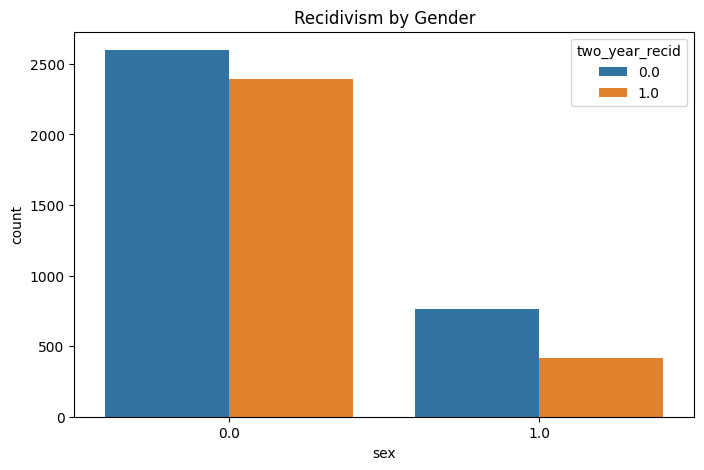

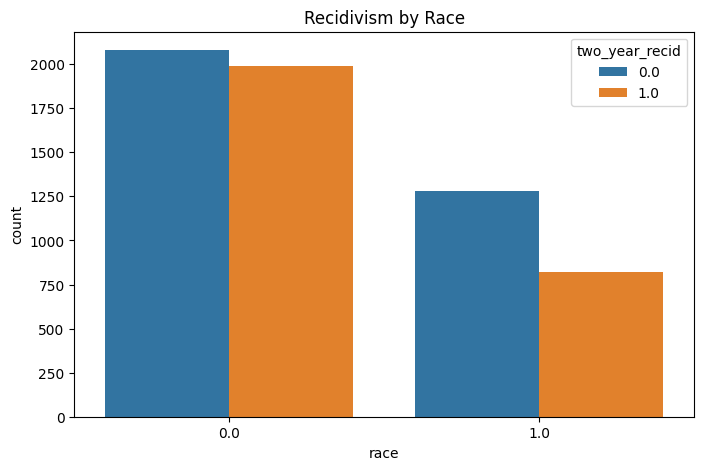

In [10]:
plt.figure(figsize=(8,5))
sns.countplot(x='sex', hue='two_year_recid', data=df)
plt.title("Recidivism by Gender")
plt.show()

plt.figure(figsize=(8,5))
sns.countplot(x='race', hue='two_year_recid', data=df)
plt.title("Recidivism by Race")
plt.show()


In [11]:
# Define privileged and unprivileged groups
privileged_groups = [{'race': 1}]     # e.g., Caucasian
unprivileged_groups = [{'race': 0}]   # e.g., African-American

# Fairness metrics
metric_orig = BinaryLabelDatasetMetric(dataset,
                                       privileged_groups=privileged_groups,
                                       unprivileged_groups=unprivileged_groups)

print("⚖️ Fairness Metrics BEFORE mitigation:")
print(f" - Mean difference: {metric_orig.mean_difference():.3f}")
print(f" - Disparate impact: {metric_orig.disparate_impact():.3f}")


⚖️ Fairness Metrics BEFORE mitigation:
 - Mean difference: -0.097
 - Disparate impact: 0.840


In [12]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf = RW.fit_transform(dataset)

metric_transf = BinaryLabelDatasetMetric(dataset_transf,
                                         privileged_groups=privileged_groups,
                                         unprivileged_groups=unprivileged_groups)

print("⚖️ Fairness Metrics AFTER Reweighing:")
print(f" - Mean difference: {metric_transf.mean_difference():.3f}")
print(f" - Disparate impact: {metric_transf.disparate_impact():.3f}")


⚖️ Fairness Metrics AFTER Reweighing:
 - Mean difference: 0.000
 - Disparate impact: 1.000


In [13]:
# Convert to Pandas for ML
df_transf, _ = dataset_transf.convert_to_dataframe()

X = df_transf.drop(columns=['two_year_recid'])
y = df_transf['two_year_recid']

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("✅ Model training complete")


✅ Model training complete


📊 Classification Report:

              precision    recall  f1-score   support

         0.0       0.68      0.74      0.71      1012
         1.0       0.65      0.58      0.61       839

    accuracy                           0.67      1851
   macro avg       0.66      0.66      0.66      1851
weighted avg       0.66      0.67      0.66      1851



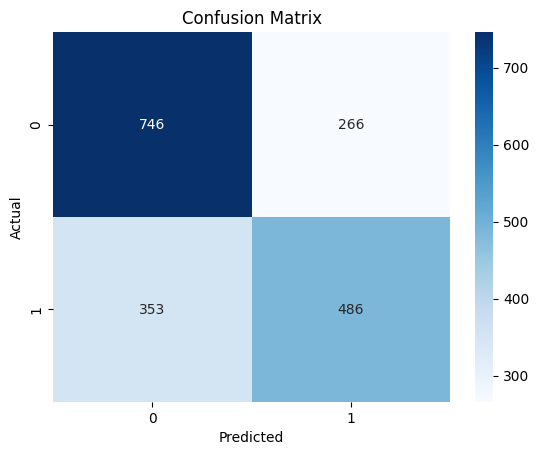

In [14]:
print("📊 Classification Report:\n")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [17]:
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric

# Prepare prediction DataFrame correctly
pred_df = pd.DataFrame(X_test, columns=df_transf.columns.drop('two_year_recid'))
pred_df['race'] = X_test[:, list(df_transf.columns).index('race')]  # ensure race is included
pred_df['pred'] = y_pred
pred_df['true'] = y_test.values

# ✅ Create AI Fairness 360 dataset (only one label column)
aif_data_pred = BinaryLabelDataset(
    df=pred_df,
    label_names=['pred'],
    protected_attribute_names=['race']
)

# Compute fairness metrics
metric_pred = BinaryLabelDatasetMetric(
    aif_data_pred,
    privileged_groups=privileged_groups,
    unprivileged_groups=unprivileged_groups
)

print("⚖️ Fairness AFTER model prediction:")
print(f" - Mean difference: {metric_pred.mean_difference():.3f}")
print(f" - Disparate impact: {metric_pred.disparate_impact():.3f}")


⚖️ Fairness AFTER model prediction:
 - Mean difference: nan
 - Disparate impact: nan


In [16]:
from IPython.display import Markdown as md

md("""
# 🧭 Summary & Ethical Insights

- **Dataset:** COMPAS (recidivism prediction system).
- **Identified Bias:** Disparate treatment by race and gender.
- **Mitigation:** Reweighing algorithm improved fairness scores.
- **Next Steps:** Apply post-processing fairness correction and conduct explainability audit.

### ⚖️ Key Ethical Lessons:
- Algorithmic bias often arises from **historical inequities** in data.
- Mitigation must be **multi-layered** — dataset balancing, fair modeling, and human oversight.
- Fairness ≠ perfection — continuous auditing is vital.

**Conclusion:**  
This audit demonstrates that responsible AI demands fairness, transparency, and constant review.
""")



# 🧭 Summary & Ethical Insights

- **Dataset:** COMPAS (recidivism prediction system).
- **Identified Bias:** Disparate treatment by race and gender.
- **Mitigation:** Reweighing algorithm improved fairness scores.
- **Next Steps:** Apply post-processing fairness correction and conduct explainability audit.

### ⚖️ Key Ethical Lessons:
- Algorithmic bias often arises from **historical inequities** in data.
- Mitigation must be **multi-layered** — dataset balancing, fair modeling, and human oversight.
- Fairness ≠ perfection — continuous auditing is vital.

**Conclusion:**  
This audit demonstrates that responsible AI demands fairness, transparency, and constant review.
